In [1]:
import os
# from osgeo import gdal

# --- 1. 设置输入和输出参数 ---

# 输入的100米分辨率栅格文件 (原始文件为100m，非10m)
input_raster_path = r"/nas/houce/GHSL/GHSL_wgs84/GHS_BUILT_S_E2025_GLOBE_R2023A_4326_3ss_V1_0.tif"

# 定义输出文件的路径
output_raster_path = r"/nas/houce/GHSL/GHS_BUILT_resample.tif"



In [2]:
import rasterio

input_raster_path2 = r"/nas/houce/GHSL/GHSL_wgs84/GHSL_resample_025.tif"

with rasterio.open(input_raster_path2) as src:
    transform = src.transform
    print(src.bounds)
    height, width = src.height, src.width

    # 获取每个像素的左上角坐标（经度、纬度）
    bounds_list = []
    for row in range(height):
        for col in range(width):
            x_min, y_max = transform * (col, row)
            x_max, y_min = transform * (col + 1, row + 1)
            bounds_list.append([x_min, y_min, x_max, y_max])  # (lon_min, lat_min, lon_max, lat_max)

# bounds_list 是每个像素的地理范围列表
print("第一个像素的bounds:", [f"{i:.4f}" for i in bounds_list[0]])
print("总像素数量:", len(bounds_list))

BoundingBox(left=-180.00041593133002, bottom=-89.15791682232421, right=179.99958406866998, top=89.09208317767579)
第一个像素的bounds: ['-180.0004', '88.8421', '-179.7504', '89.0921']
总像素数量: 1026720


In [3]:
import rasterio
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

# 1. 读取重采样后的影像
input_raster_path2 = r"/nas/houce/GHSL/GHSL_wgs84/GHSL_resample_025.tif"

with rasterio.open(input_raster_path2) as src:
    img = src.read(1)
    height, width = src.height, src.width
    transform = src.transform
    
    # 2. 获取像素中心点坐标和对应的值
    points = []
    values = []
    
    for row in range(height):
        for col in range(width):
            # 获取像素中心点坐标
            x_center, y_center = transform * (col + 0.5, row + 0.5)
            
            # 记录坐标和对应的像素值
            # 筛选掉NoData值
            pixel_value = img[row, col]
            if pixel_value != src.nodata and not np.isnan(pixel_value):
                points.append((x_center, y_center))
                values.append(pixel_value)
    
    # 转为numpy数组，加速计算
    points = np.array(points)
    values = np.array(values)

# 3. 为grid_df创建规则的经纬度网格中心点
# 经度和纬度范围
lon_start, lon_end = -180, 180
lat_start, lat_end = -90, 90
res = 2.5

# 生成格网
lon_bins = np.arange(lon_start, lon_end, res) + res/2  # 加上半个分辨率得到中心点
lat_bins = np.arange(lat_start, lat_end, res) + res/2

grid_list = []
for lat in lat_bins:  # 纬度在外循环，使顺序与格网的行优先存储一致
    for lon in lon_bins:
        grid_list.append([lon - res/2, lat - res/2, lon + res/2, lat + res/2])

grid_df = pd.DataFrame(grid_list, columns=["lon_min", "lat_min", "lon_max", "lat_max"])

# 4. 创建目标网格中心点坐标
grid_centers = np.array([
    [(row['lon_min'] + row['lon_max'])/2, (row['lat_min'] + row['lat_max'])/2] 
    for _, row in grid_df.iterrows()
])

# 5. 使用griddata进行插值
# method可选'linear', 'nearest', 'cubic'
interpolated_values = griddata(points, values, grid_centers, method='linear', fill_value=np.nan)

# 6. 将插值结果添加到grid_df
grid_df['value'] = interpolated_values

# 7. 输出结果
print(grid_df.head())
print(f"有效格网数: {np.sum(~np.isnan(grid_df['value']))}")

   lon_min  lat_min  lon_max  lat_max  value
0   -180.0    -90.0   -177.5    -87.5    1.0
1   -177.5    -90.0   -175.0    -87.5    1.0
2   -175.0    -90.0   -172.5    -87.5    1.0
3   -172.5    -90.0   -170.0    -87.5    1.0
4   -170.0    -90.0   -167.5    -87.5    1.0
有效格网数: 10368


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
pivot_table = pd.pivot_table(
    grid_df,
    values='value',
    index='lat_min',
    columns='lon_min',
    aggfunc='mean'
)

# fig, ax = plt.subplots(figsize=(20, 8))
# sns.heatmap(pivot_table, ax=ax)
# plt.show()

(1114, 5)


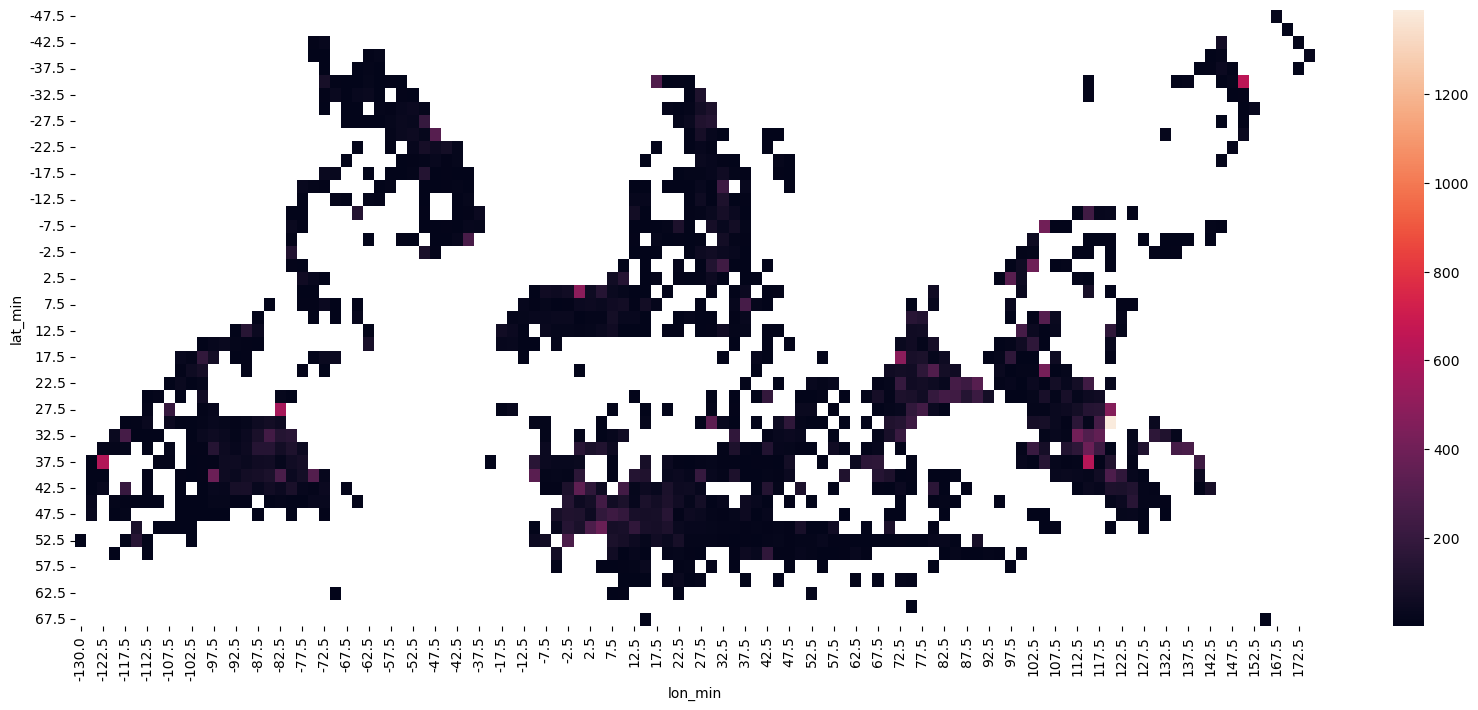

In [6]:
threshold = 2
print(grid_df[grid_df['value']>threshold].shape)
pivot_table2 = pd.pivot_table(
    grid_df[grid_df['value']>threshold],
    values='value',
    index='lat_min',
    columns='lon_min',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(pivot_table2, ax=ax)
plt.show()


In [7]:
grid_df[grid_df['value']>threshold].to_csv('human_settlement_grid_cells_deg_25.csv', index=None)

In [1]:
diff_threshold = [2,25]
grid_df_diff = set(grid_df[grid_df['value']>diff_threshold[0]].index) - set(grid_df[grid_df['value']>diff_threshold[1]].index)
pivot_table_diff = pd.pivot_table(
    grid_df.iloc[list(grid_df_diff)],
    values='value',
    index='lat_min',
    columns='lon_min',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(pivot_table_diff, ax=ax)
plt.show()

NameError: name 'grid_df' is not defined

In [ ]:
import rasterio
import numpy as np
import pandas as pd
from rasterio.windows import from_bounds

# 1. 从grid_df随机选择100个点
threshold = 10
sample_df = grid_df[grid_df['value']>threshold].sample(n=2000, random_state=42)

# 2. 从原始影像中获取这些点的栅格值
input_raster_path = r"/nas/houce/GHSL/GHSL_wgs84/GHS_BUILT_S_E2025_GLOBE_R2023A_4326_3ss_V1_0.tif"

with rasterio.open(input_raster_path) as src:
    # 创建结果列表
    results = []
    
    # 遍历抽样的格网
    for idx, row in sample_df.iterrows():
        # 获取格网边界
        lon_min = row['lon_min']
        lat_min = row['lat_min']
        lon_max = row['lon_max']
        lat_max = row['lat_max']
        
        try:
            # 尝试从影像中提取对应区域
            window = from_bounds(lon_min, lat_min, lon_max, lat_max, src.transform)
            if window.width > 0 and window.height > 0:
                # 读取窗口数据
                data = src.read(1, window=window)
                
                # 计算均值(如果全为nodata则返回np.nan)
                if np.all(data == src.nodata):
                    mean_value = np.nan
                else:
                    # 排除nodata值计算均值
                    valid_data = data[data != src.nodata]
                    mean_value = np.mean(valid_data) if len(valid_data) > 0 else np.nan
                
                # 添加到结果列表
                results.append({
                    'lon_min': lon_min,
                    'lat_min': lat_min,
                    'lon_max': lon_max,
                    'lat_max': lat_max,
                    'interpolated_value': row.get('value', np.nan),  # 插值得到的值
                    'actual_value': mean_value,                      # 实际栅格值
                    'difference': row.get('value', np.nan) - mean_value if not np.isnan(mean_value) else np.nan
                })
            else:
                results.append({
                    'lon_min': lon_min,
                    'lat_min': lat_min,
                    'lon_max': lon_max,
                    'lat_max': lat_max,
                    'interpolated_value': row.get('value', np.nan),
                    'actual_value': np.nan,
                    'difference': np.nan
                })
        except Exception as e:
            # 如果提取失败(比如超出影像范围)，记录失败信息
            results.append({
                'lon_min': lon_min,
                'lat_min': lat_min,
                'lon_max': lon_max,
                'lat_max': lat_max,
                'interpolated_value': row.get('value', np.nan),
                'actual_value': np.nan,
                'difference': np.nan,
                'error': str(e)
            })

# 3. 将结果汇总到dataframe
results_df = pd.DataFrame(results)

# 4. 显示结果
# print(results_df.head())
print(f"有效样本数: {len(results_df)}")

有效样本数: 2000


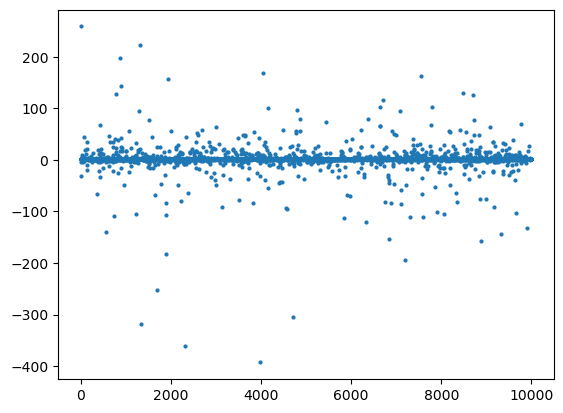

In [ ]:
# sns.kdeplot(data=results_df, x='difference', fill=True)
plt.plot(results_df['difference'], marker='o', linestyle='None', markersize=2)

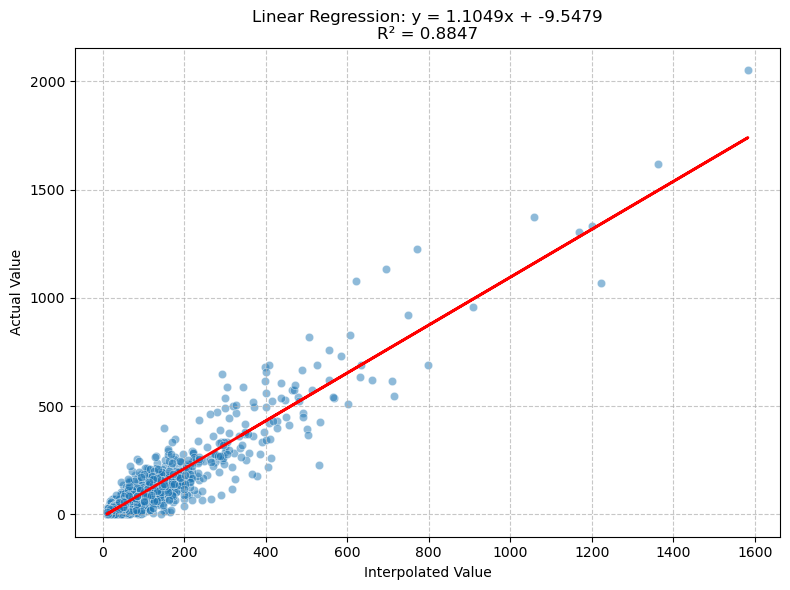

回归方程: y = 1.1049x + -9.5479
R²: 0.8847


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# 移除包含NaN值的行
valid_results = results_df.dropna(subset=['interpolated_value', 'actual_value'])

# 提取X和y
X = valid_results['interpolated_value'].values.reshape(-1, 1)
y = valid_results['actual_value'].values

# 拟合线性回归模型
model = LinearRegression()
model.fit(X, y)

# 获取系数
slope = model.coef_[0]
intercept = model.intercept_

# 预测值
y_pred = model.predict(X)

# 计算R²
r2 = r2_score(y, y_pred)

# 可视化结果
plt.figure(figsize=(8, 6))
sns.scatterplot(data=valid_results, x='interpolated_value', y='actual_value', alpha=0.5)
plt.plot(X, y_pred, color='red', linewidth=2)
plt.title(f'Linear Regression: y = {slope:.4f}x + {intercept:.4f}\nR² = {r2:.4f}')
plt.xlabel('Interpolated Value')
plt.ylabel('Actual Value')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"回归方程: y = {slope:.4f}x + {intercept:.4f}")
print(f"R²: {r2:.4f}")

0.0


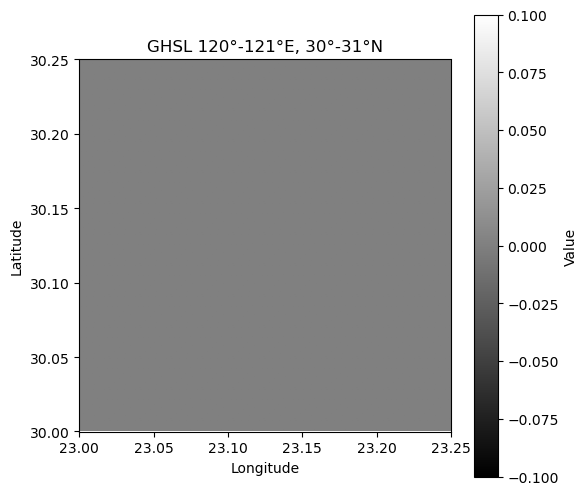

In [ ]:
import rasterio
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt

input_raster_path = r"/nas/houce/GHSL/GHSL_wgs84/GHS_BUILT_S_E2025_GLOBE_R2023A_4326_3ss_V1_0.tif"

# 指定经纬度范围

lon_min, lon_max = bounds[0], bounds[2]
lat_min, lat_max = bounds[1], bounds[3]

with rasterio.open(input_raster_path) as src:
    window = from_bounds(lon_min, lat_min, lon_max, lat_max, src.transform)
    img_crop4 = src.read(1, window=window)
    print(img_crop4.mean())

    plt.figure(figsize=(6, 6))
    plt.imshow(img_crop4, cmap='gray', extent=[lon_min, lon_max, lat_min, lat_max])
    plt.title("GHSL 120°-121°E, 30°-31°N")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(label="Value")
    plt.show()

In [ ]:
from osgeo import gdal

input_raster_path = r"/nas/houce/GHSL/GHSL_wgs84/GHS_BUILT_S_E2025_GLOBE_R2023A_4326_3ss_V1_0.tif"
output_raster_path = r"/nas/houce/GHSL/GHS_BUILT_resample_025.tif"

# 构建WarpOptions对象
warp_options = gdal.WarpOptions(
    xRes=0.25,
    yRes=0.25,
    resampleAlg='average',      # 平均值重采样
    format='GTiff',
    dstNodata=-200,
    multithread=True,
    options=['NUM_THREADS=ALL_CPUS']
)

# 使用gdal.Warp进行重采样
gdal.Warp(
    destNameOrDestDS=output_raster_path,
    srcDSOrSrcDSTab=input_raster_path,
    options=warp_options
)

print("重采样完成，输出文件路径：", output_raster_path)

ERROR 1: Zero positional arguments expected


TypeError: in method 'wrapper_GDALWarpDestName', argument 4 of type 'GDALWarpAppOptions *'